# MaintKG Case Study: Using Neo4J Cypher Queries to Address Expert Competency Query
![Maintenance](https://img.shields.io/badge/Maintenance-Analysis-blue)
![Python](https://img.shields.io/badge/Python-3.9-green)
![Neo4j](https://img.shields.io/badge/Neo4j-4.4+-orange)

## Overview
This notebook demonstrates example queries that map to expert competency questions for the MaintKG case study. Through these queries, we explore maintenance patterns, component relationships, and failure analysis within the knowledge graph.

### Environment Setup
- Python virtual environment activated (`venv`)
- Required packages installed (see `requirements.txt`)
- Python 3.9 or later

### Database Requirements
- Neo4j database instance running (version 4.4+)
- MaintKG populated with case study data
- Valid database credentials configured

### Output Information
- Plots are automatically saved to `./assets` in PDF format
- Query results can be exported to CSV files
- Visualizations use matplotlib and seaborn libraries


## Table of Contents
1. [Notebook Setup](#notebook-setup)
2. [Cypher Queries](#cypher-queries)
    1. [Identification of Failures and Defects](#identification-of-failures-and-defects)
    2. [Analysis of Reliability Trends](#analysis-of-reliability-trends-and-benchmarking-of-equipment-performance)
    3. [Analysis of Maintenance Costs](#analysis-of-maintenance-costs-and-budget-allocation)
    4. [Knowledge Discovery and Management](#knowledge-discovery-and-management)


## Setup

In [1]:
from itertools import product

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from neo4j import GraphDatabase
import numpy as np
import pandas as pd
import seaborn as sns

from maintkg.settings import Settings

Initialise the Neo4J connection

In [2]:
settings = Settings()

driver = GraphDatabase.driver(settings.neo4j.uri, auth=(settings.neo4j.username, settings.neo4j.password), database=settings.neo4j.database)

In [3]:
def fetch_data(query: str) -> pd.DataFrame:
    """Fetch data from Neo4j and return a DataFrame."""
    with driver.session() as session:
        result = session.run(query)
        data = result.data()    # Fetch all results    
        df = pd.DataFrame(data) # Convert the list of dictionaries to a DataFrame
        return df

## Cypher Queries

### Identification of Failures and Defects

In [4]:
# CQ1. What is the top-n distribution of undesirable states for components on all hydraulic shovels?
query_1 = '''
MATCH p=(r:Record)-[:MENTIONS]->(n)-[rp:HAS_PATIENT]->(m)-[:MENTIONS]-(r)
WHERE id(rp) IN r.relationIds AND labels(n)[0] CONTAINS 'State' AND labels(m)[0] CONTAINS 'Object'
WITH r.floc AS asset, n.name AS state, m.name AS component, COUNT(p) AS count
WHERE count > 10
RETURN asset, state, component, count
ORDER BY state, component
'''

In [5]:
def create_query_1_heatmap(query: str, save_path: str = None) -> None:
    ''''''
    df = fetch_data(query=query)
    # Get all unique components and states to ensure all combinations are considered
    components = df["component"].unique()
    states = df["state"].unique()

    # List of unique assets
    assets = df["asset"].unique()

    # Create a DataFrame that includes all combinations for each asset
    all_combinations = pd.DataFrame(
        list(product(assets, components, states)), columns=["asset", "component", "state"]
    )

    # Merge with original df to include counts
    full_df = pd.merge(
        all_combinations, df, on=["asset", "component", "state"], how="left"
    ).fillna(0)

    full_df["count"] = full_df["count"].astype(int)

    # Create a pivot table for each asset
    pivot_tables = {
        asset: full_df[full_df["asset"] == asset].pivot(
            index="component", columns="state", values="count"
        )
        for asset in assets
    }

    # Sort the pivot_tables dictionary by asset keys
    pivot_tables = {asset: pivot_tables[asset] for asset in sorted(pivot_tables)}

    # Determine the global min and max for the counts, to use in color scale normalization
    vmin = min(pivot.min().min() for pivot in pivot_tables.values())
    vmax = max(pivot.max().max() for pivot in pivot_tables.values())

    # Create subplots
    fig, axes = plt.subplots(
        1, len(assets), sharey=True, gridspec_kw={"wspace": 0.1}, figsize=(14, 8)
    )

    cmap = sns.color_palette("rocket_r", as_cmap=True)
    cmap.set_bad("whitesmoke")


    # Plot each pivot table in a subplot
    for i, (asset, pivot_table) in enumerate(pivot_tables.items()):
        ax = axes[i]
        pivot_table = pivot_table.replace(0, np.nan)

        sns.heatmap(
            pivot_table,
            ax=ax,
            cbar=i == len(assets) - 1,
            vmin=vmin,
            vmax=vmax,
            cmap=cmap,
            linewidth=4,
            cbar_kws={
                "shrink": 0.5,
                "label": "Count" if i == len(assets) - 1 else ""
                },
        )

        # Set title (asset name)
        ax.set_title("Asset " + asset, fontsize=12, pad=20)

        # Configure y-axis (years)
        ax.set_ylabel("Component" if i == 0 else "", fontsize=12)  # Only show on first subplot
        ax.yaxis.set_tick_params(labelsize=12, rotation=0)  # Horizontal year labels

        # Configure x-axis (activities)
        ax.set_xlabel("State", fontsize=12)
        ax.xaxis.set_tick_params(labelsize=12, rotation=90)  # Vertical activity labels

        # If this is the last subplot (has colorbar)
        if i == len(assets) - 1:
            # Get the colorbar and adjust its properties
            cbar = ax.collections[0].colorbar
            cbar.ax.tick_params(labelsize=12)  # Set tick label size
            cbar.ax.set_ylabel("Count", fontsize=12)  # Set label size


    # Save plot if path is provided
    if save_path:
        if not save_path.endswith('.pdf'):
            save_path += '.pdf'
        
        plt.savefig(
            save_path,
            format='pdf',
            dpi=300,
            bbox_inches='tight',
            pad_inches=0.1
        )
        print(f"Plot saved as: {save_path}")


    # Display the plot
    plt.show()

Plot saved as: ./assets/query_1_heatmap_plot.pdf


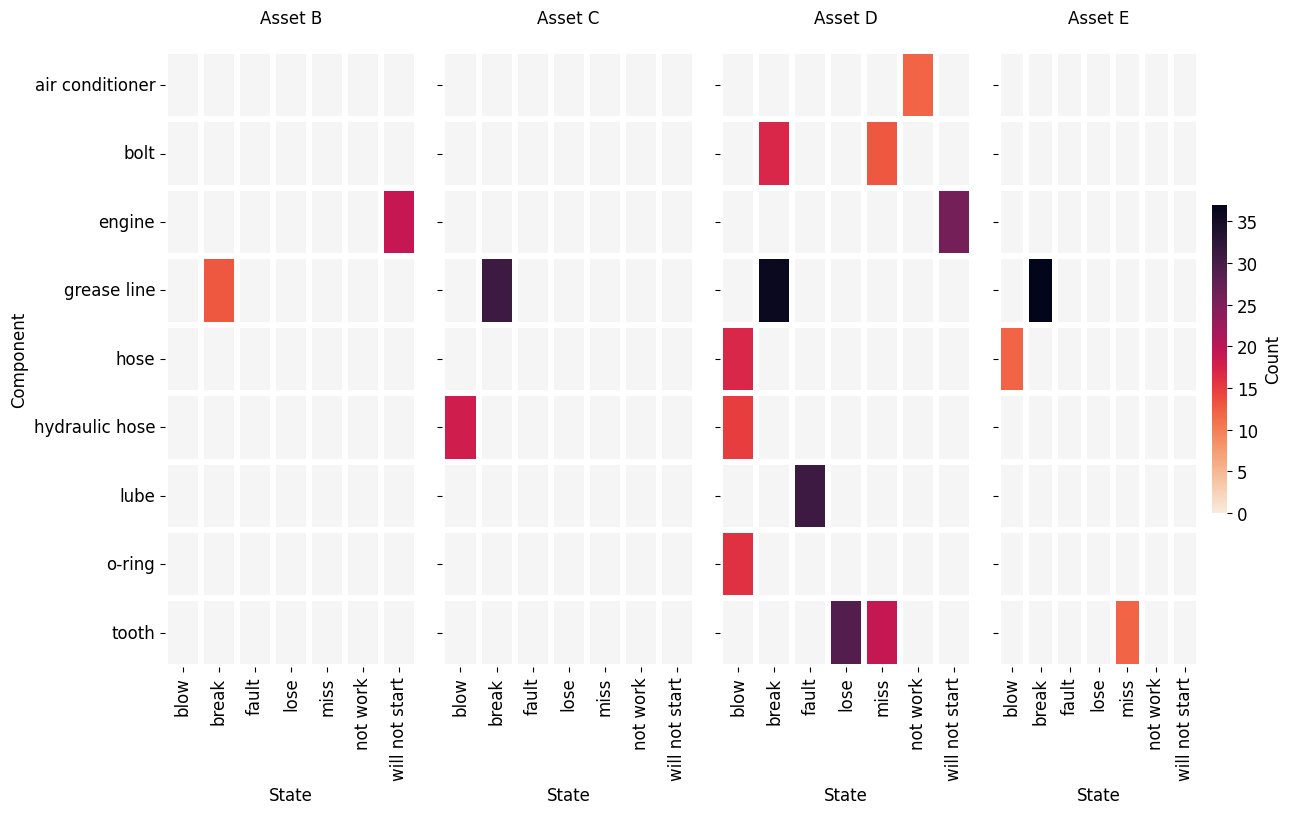

In [6]:
create_query_1_heatmap(query=query_1, save_path='./assets/query_1_heatmap_plot.pdf')

In [7]:
# CQ2. What are the frequency and percentage distribution of failure states for component X on asset Y? (X = air conditioner, Y = hydraulic shovel)
query_2 = '''
MATCH (r:Record)-[:MENTIONS]->(n:`State/UndesirableState/FailedState`)-[rp:HAS_PATIENT]->(m)<-[:MENTIONS]-(r)
WHERE id(rp) IN r.relationIds AND m.name = 'air conditioner'
WITH r.floc AS system, m.name AS component, n.name AS state

WITH system, component, state, COUNT(state) AS stateCount
ORDER BY system, component, stateCount DESC
WITH system, component, COLLECT(state) AS states, COLLECT(stateCount) AS stateCounts

WITH system, component, states, stateCounts, REDUCE(s = 0, i IN stateCounts | s + i) AS totalStates

UNWIND range(0, size(states)-1) AS idx
WITH system, component, states[idx] AS state, stateCounts[idx] AS stateCount, totalStates,
     (stateCounts[idx] * 100.0 / totalStates) AS percentage

RETURN system, component, state, stateCount, percentage
ORDER BY system, component, percentage
'''

# Note: The following query needs to be run in Neo4j Browser to get the subgraph.
query_2_subgraph = '''
MATCH p=(r:Record)-[:MENTIONS]->(n:`State/UndesirableState/FailedState`)-[rp:HAS_PATIENT]->(m)<-[:MENTIONS]-(r)
WHERE id(rp) IN r.relationIds AND m.name = 'air conditioner'
RETURN p
'''

In [8]:
def create_query_2_barchart(query: str, save_path: str = None):
    """
    Creates a stacked bar chart showing the distribution of air conditioner states by system,
    using an academic styling consistent with other visualizations.
    
    Args:
        query (str): Cypher query to fetch the data
        save_path (str, optional): Path where to save the PDF file. 
                                 If None, plot will only be displayed.
        
    Returns:
        matplotlib.figure.Figure: The generated plot
    """
    # Data
    data = {
        'system': ['A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'C', 'C', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'E', 'E'],
        'component': ['air conditioner']*20,
        'state': [
            'no power', 'blowing hot air', 'no power', 'blowing hot', 'will not turn off', 'unserviceable', 
            'blowing hot air', 'not getting cold', 'not work', 'not work', 'not cool', 'unserviceable', 
            'not cool', 'blowing hot air', 'no power', 'blowing hot', 'not getting cold', 'not work', 
            'not work', 'not cool'
        ],
        'stateCount': [1, 3, 1, 1, 1, 2, 2, 2, 3, 1, 10, 1, 2, 3, 3, 3, 4, 12, 2, 7],
        'percentage': [
            25.0, 75.0, 8.33, 8.33, 8.33, 16.67, 
            16.67, 16.67, 25.0, 9.09, 90.91, 3.57, 
            7.14, 10.71, 10.71, 10.71, 14.29, 
            42.86, 22.22, 77.78
        ]
    }

    # Create DataFrame and pivot
    df = pd.DataFrame(data)
    df_pivot = df.pivot_table(
        index='system',
        columns='state',
        values='percentage',
        aggfunc='sum',
        fill_value=0
    )

    # Setup plot
    plt.style.use('seaborn-v0_8-paper')
    fig, ax = plt.subplots(figsize=(14, 8))

    # Add grid lines
    ax.grid(True, linestyle='--', alpha=0.3, color='gray', zorder=0)


    # Define academic color palette
    colors = [
        '#4A6FA5',  # Steel blue
        '#77A690',  # Sage green
        '#9E857C',  # Warm gray
        '#8B7355',  # Deep taupe
        '#7B8B6F',  # Muted olive
        '#6F7B8B',  # Slate blue
        '#8B6F7B',  # Dusty rose
        '#7B8B8B',  # Steel gray
    ]

    # Plot stacked bars and add labels
    bottom = pd.Series([0]*len(df_pivot), index=df_pivot.index)
    for i, column in enumerate(df_pivot.columns):
        values = df_pivot[column]
        bars = ax.bar(
            df_pivot.index,
            values,
            bottom=bottom,
            label=f"{i+1}. {column}",  # Add number to legend
            color=colors[i],
            edgecolor='black',
            linewidth=0.5,
            zorder=3
        )
        
        # Add labels inside the bars
        for j, bar in enumerate(bars):
            height = bar.get_height()
            if height > 5:  # Only show label if section is large enough (>5%)
                x = bar.get_x() + bar.get_width()/2
                y = bottom.iloc[j] + height/2  # Use iloc to access bottom values
                ax.text(
                    x, y,
                    str(i+1),  # Show state number
                    ha='center',
                    va='center',
                    color='white',
                    fontweight='bold',
                    fontsize=10
                )
        bottom += values
    
    # Customize plot appearance
    ax.set_xlabel('Asset', fontsize=14)
    ax.set_ylabel('Percentage (%)', fontsize=14)
    ax.set_ylim(0, 100)
    
    # Set tick label font sizes
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.xticks(rotation=0)
    
    # Adjust spine appearance
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    
    # Add centered legend
    box = ax.get_position()
    # Shrink the width of the plot to make room for the legend
    ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])
    
    # Add legend on the right
    legend = ax.legend(
        title='State',
        bbox_to_anchor=(1, 0.5),  # Position legend to the right
        loc='center left',           # Anchor legend on the left side
        fontsize=12,
        frameon=True,
        edgecolor='black',
        fancybox=False,
        ncol=1                       # Single column
    )
    legend.get_title().set_fontsize(12)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save plot if path is provided
    if save_path:
        if not save_path.endswith('.pdf'):
            save_path += '.pdf'
        
        plt.savefig(
            save_path,
            format='pdf',
            dpi=300,
            bbox_inches='tight',
            pad_inches=0.1
        )
        print(f"Plot saved as: {save_path}")

Plot saved as: ./assets/query_2_stacked_bar_plot.pdf


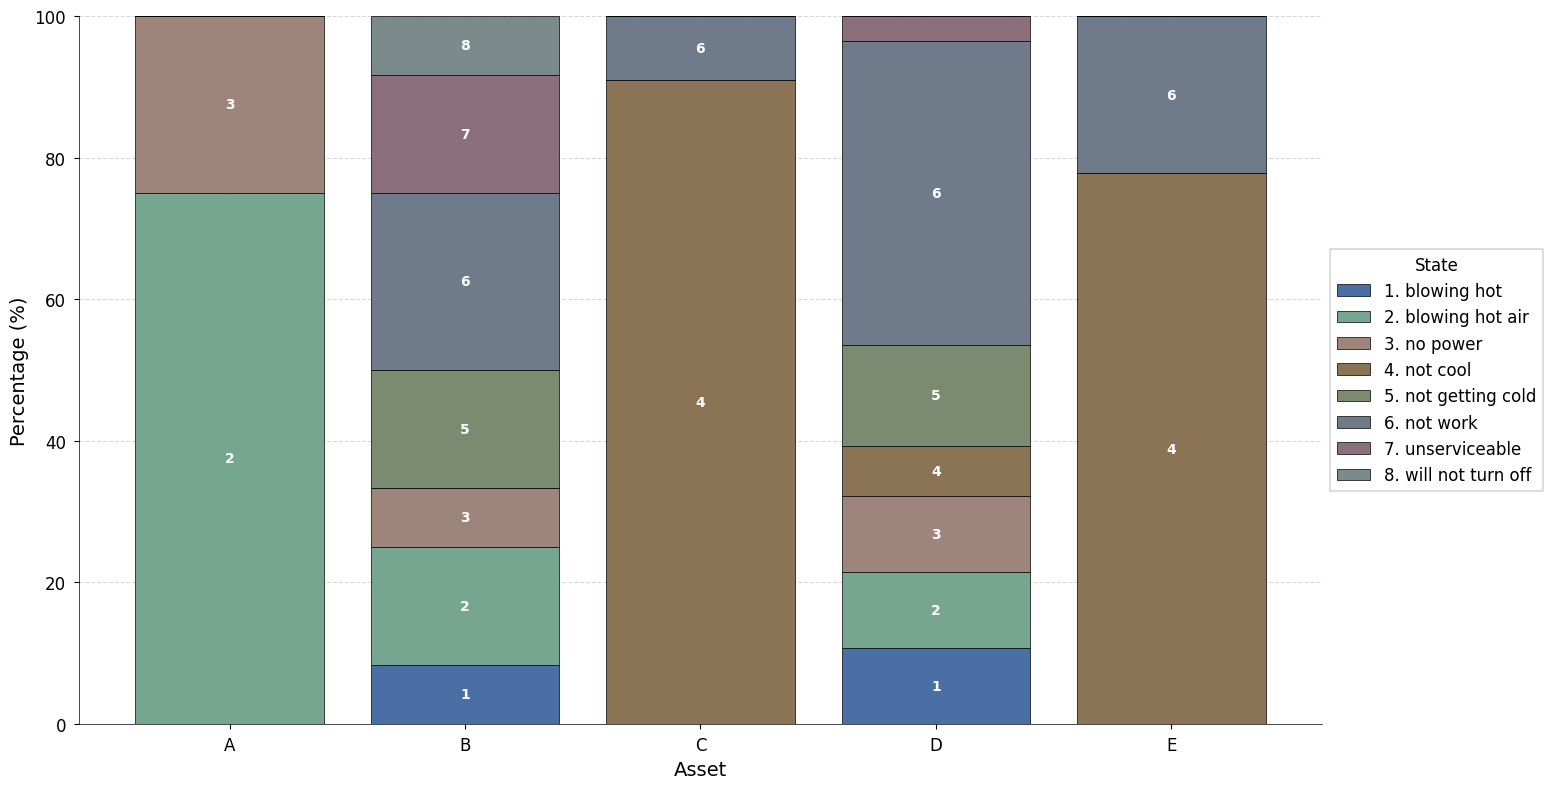

In [9]:
create_query_2_barchart(query=query_2, save_path='./assets/query_2_stacked_bar_plot.pdf')

### Analysis of Reliability Trends and Benchmarking of Equipment Performance

In [10]:
# CQ3. What is the mean-time-to-failure (MTBF) for component X on the hydraulic shovels? (X = engine)
query_3 = '''
MATCH (r:Record)-[:MENTIONS]->(m:`State/UndesirableState/FailedState`)-[rp:HAS_PATIENT]-(n)<-[:MENTIONS]-(r)
WHERE id(rp) IN r.relationIds AND n.name = 'engine'
WITH r.floc AS system, m.name AS event, n.name AS component, r.text AS text, r.start_date AS start_date, r.cost AS cost
WITH system, component, COUNT(*) AS count, collect(start_date) AS dates
WITH system, component, count, dates, apoc.coll.sort(dates) AS sortedDates
WITH system, component, count, sortedDates,
     CASE WHEN size(sortedDates) > 1 THEN 
          reduce(s = 0, i IN range(1, size(sortedDates) - 1) | 
              s + duration.inDays(date(sortedDates[i - 1]), date(sortedDates[i])).days) / (size(sortedDates) - 1)
     ELSE 0 END AS avgDaysBetweenEvents
WHERE avgDaysBetweenEvents > 0
RETURN system AS Asset, ABS(avgDaysBetweenEvents) AS MTBF, count As Events
ORDER BY Asset
'''

In [11]:
query_3_df = fetch_data(query=query_3)
query_3_df

,Asset,MTBF,Events
0,A,217,9
1,B,30,26
2,C,462,2
3,D,71,35
4,E,137,11


### Analysis of Maintenance Costs and Budget Allocation

In [12]:
# Calculate the total yearly maintenance and support costs for hydraulic shovels.
query_4 = '''
MATCH (r:Record)-[:MENTIONS]->(n)
WHERE ANY(label IN labels(n) WHERE label STARTS WITH 'Activity/MaintenanceActivity/' OR label STARTS WITH 'Activity/SupportingActivity/')
WITH r, n, r.start_date.year AS year, r.floc AS asset,
     split(substring(replace(labels(n)[0], 'Activity', ''),1),'/')[0] AS activityType
RETURN year, asset, activityType, COUNT(n) AS events, SUM(r.cost) AS totalCost
ORDER BY year, asset
'''

In [13]:
def create_query_4_cluster_bar_plot(query: str, save_path: str = None):
    """
    Creates a bar plot showing costs by year and asset, with side-by-side assets
    and stacked maintenance/supporting activities.
    
    Args:
        query (str): Cypher query to fetch the data
        save_path (str, optional): Path where to save the PDF file. 
                                 If None, plot will only be displayed.
        
    Returns:
        matplotlib.figure.Figure: The generated plot
    """
    # Fetch and preprocess data
    df = fetch_data(query=query)
    df = df[df['totalCost'] > 10000] # Remove rows where totalCost is 10,000
    df['totalCost'] = df['totalCost'] / 1000000 # Convert totalCost to millions of dollar
    # df = df[df['asset'] == 'D'] # Limit df to single asset

    # Create pivot table for stacking
    pivot_df = df.pivot_table(
        index=['year', 'asset'],
        columns='activityType',
        values='totalCost',
        aggfunc='sum',
        fill_value=0
        ).reset_index()

    # Setup plot with a white background
    plt.style.use('seaborn-v0_8-paper')  # Use academic-style base
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Add grid lines
    ax.grid(True, linestyle='--', alpha=0.3, color='gray', zorder=0)
    
    # Define plot parameters
    years = sorted(pivot_df['year'].unique())
    assets = sorted(pivot_df['asset'].unique())
    n_years = len(years)
    n_assets = len(assets)
    
    # Calculate bar positioning
    bar_width = 0.8 / n_assets
    year_positions = range(n_years)
    
    # Define academic color palette
    # Using a combination of muted, professional colors suitable for publications
    base_colors = [
        '#4A6FA5',  # Steel blue
        '#98A6B3',  # Slate gray
        '#77A690',  # Sage green
        '#9E857C',  # Warm gray
        '#A69B7B',  # Taupe
    ]
    
    # Create color map with lighter and darker versions for each asset
    color_map = {}
    for i, asset in enumerate(assets):
        base_color = base_colors[i % len(base_colors)]
        # Convert to RGB for manipulation
        rgb_color = mcolors.to_rgb(base_color)
        
        # Create lighter version for Maintenance (20% lighter)
        lighter_color = tuple(min(1.0, c * 1.2) for c in rgb_color)
        # Create darker version for Supporting (30% darker)
        darker_color = tuple(max(0.0, c * 0.7) for c in rgb_color)
        
        color_map[f'{asset}_Maintenance'] = lighter_color
        color_map[f'{asset}_Supporting'] = darker_color
    
    # Plot bars for each asset
    for asset_idx, asset in enumerate(assets):
        # Calculate x positions for this asset's bars
        x_positions = [x + (asset_idx - n_assets/2 + 0.5) * bar_width for x in year_positions]
        
        for year_idx, year in enumerate(years):
            # Get data for this year and asset
            mask = (pivot_df['year'] == year) & (pivot_df['asset'] == asset)
            if any(mask):
                maintenance_cost = pivot_df.loc[mask, 'Maintenance'].iloc[0]
                supporting_cost = pivot_df.loc[mask, 'Supporting'].iloc[0]
            else:
                maintenance_cost = 0
                supporting_cost = 0
            
            # Plot Maintenance (bottom bar)
            ax.bar(x_positions[year_idx], maintenance_cost, 
                  bar_width, 
                  color=color_map[f'{asset}_Maintenance'],
                  label=f'{asset} - Maintenance' if year_idx == 0 else "",
                  zorder=3,
                  edgecolor='black',     # Add black border
                  linewidth=0.5)         # Thin border
            
            # Plot Supporting (top bar)
            ax.bar(x_positions[year_idx], supporting_cost,
                  bar_width,
                  bottom=maintenance_cost,
                  color=color_map[f'{asset}_Supporting'],
                  label=f'{asset} - Supporting' if year_idx == 0 else "",
                  zorder=3,
                  edgecolor='black',     # Add black border
                  linewidth=0.5)         # Thin border
    
    # Customize plot appearance
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Total Cost ($M)', fontsize=14)
    ax.set_xticks(year_positions)
    ax.set_xticklabels(years, rotation=45)
    
    # Set tick label font sizes
    ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust the number 12 to your desired font size

    # Adjust spine appearance
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    
    # Add centered legend
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])
    
    # Add legend at the top center
    legend = ax.legend(
        title='Activity Type and Asset',
        loc='upper center',
        fontsize=12,
        frameon=True,
        edgecolor='black',
        fancybox=False,
        ncol=2  # Arrange legend items in two columns
    )
    legend.get_title().set_fontsize(12)  # Adjust legend title size
    
    # Adjust layout
    plt.tight_layout()

    # Save plot if path is provided
    if save_path:
        # Ensure the path ends with .pdf
        if not save_path.endswith('.pdf'):
            save_path += '.pdf'
        
        # Save with high DPI and tight layout
        plt.savefig(
            save_path,
            format='pdf',
            dpi=300,
            bbox_inches='tight',
            pad_inches=0.1
        )
        print(f"Plot saved as: {save_path}")


    # Display the plot
    plt.show()

Plot saved as: ./assets/query_4_cluster_bar_plot.pdf


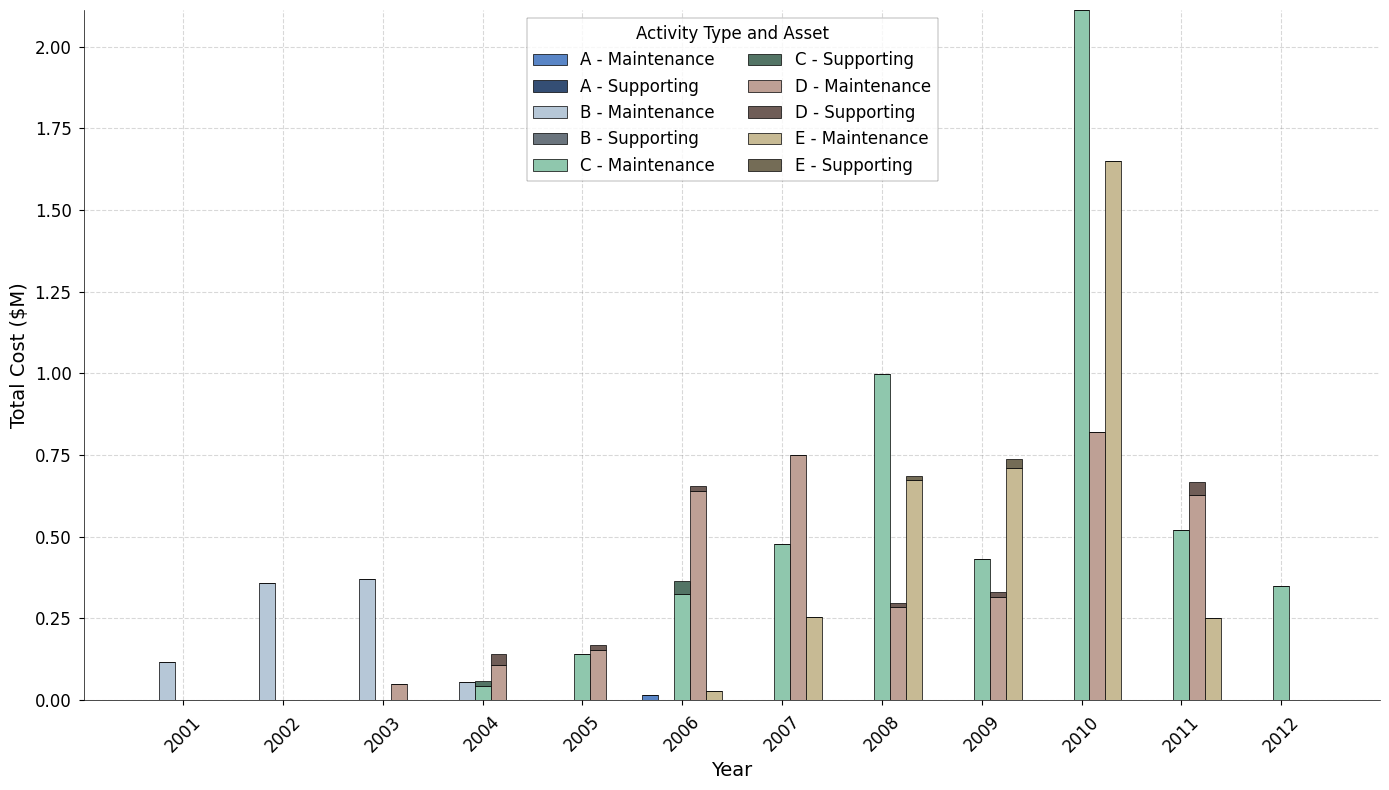

In [14]:
create_query_4_cluster_bar_plot(query=query_4, save_path='./assets/query_4_cluster_bar_plot.pdf')

In [15]:
# CQ5. How have the costs associated with X changed over the period N for asset Y? (X = 'Activity/MaintenanceActivity/Replace', N = 2006-2011, Y = hydraulic shovel)
query_5 = '''
MATCH (sys:System)--(r:Record)-[:MENTIONS]->(n:`Activity/MaintenanceActivity/Replace`)-[rp:HAS_PATIENT]-(o)-[:MENTIONS]-(r)
WHERE id(rp) IN r.relationIds AND sys.name = 'D'
WITH r, n, r.start_date.year AS year, o.name AS component
WHERE year >= 2006 AND year <= 2011
RETURN year, COUNT(n) AS eventCount, COLLECT(DISTINCT component) AS components, SUM(r.cost) AS totalCost
ORDER BY year ASC
'''

In [16]:
query_5_df = fetch_data(query=query_5)
query_5_df

,year,eventCount,components,totalCost
0,2006,3,"[lube changeover valve, grease pump, tooth]",7373.90
1,2007,9,"[light, indicator, hydraulic hose, coolant lin...",17929.00
2,2008,19,"[light, o-ring, hose, grease screen, lube pump...",176009.76
3,2009,22,"[heater valve, belt, coupling, drive coupling,...",229970.72
4,2010,15,"[idler, cylinder, stick arm, mount, slew brake...",380345.45
5,2011,13,"[track idler, brake, final drive, drain hose, ...",343516.28


In [17]:
# CQ6. What is the distribution of costs associated with maintenance activities performed on the hydraulic shovels?
query_6 = '''
MATCH (sys:System)--(r:Record)-[:MENTIONS]->(n)-[rp:HAS_PATIENT]-(o)-[:MENTIONS]-(r)
WHERE labels(n)[0] CONTAINS 'Activity/MaintenanceActivity' AND id(rp) IN r.relationIds
WITH r, n, sys, r.start_date.year AS year, o.name AS component
RETURN year, sys.name AS asset, labels(n)[0] AS activity, COUNT(r) AS recordCount, SUM(r.cost) AS totalCost
ORDER BY year ASC
'''

In [18]:
def create_query_6_heatmap(query: str, save_path: str=None):
    df = fetch_data(query=query)
    # Truncate activities to their last part
    df['activity'] = df['activity'].apply(lambda x: x.split('/')[-1])

    # Get all unique activities and years to ensure all combinations are considered
    activities = df["activity"].unique()
    years = df["year"].unique()
    # List of unique assets
    assets = df["asset"].unique()

    # Create a DataFrame that includes all combinations for each asset
    all_combinations = pd.DataFrame(
        list(product(assets, activities, years)), columns=["asset", "activity", "year"]
    )

    # Merge with original df to include counts
    full_df = pd.merge(
        all_combinations, df, on=["asset", "activity", "year"], how="left"
    ).fillna(0)
    full_df["totalCost"] = full_df["totalCost"].astype(float)

    # Convert totalCost to millions
    full_df["totalCost"] = full_df["totalCost"] / 1e6

    # Create a pivot table for each asset
    pivot_tables = {
        asset: full_df[full_df["asset"] == asset].pivot(
            index="year", columns="activity", values="totalCost"
        )
        for asset in assets
    }

    # Sort the pivot_tables dictionary by asset keys
    pivot_tables = {asset: pivot_tables[asset] for asset in sorted(pivot_tables)}

    # Determine the global min and max for the counts, to use in color scale normalization
    vmin = min(pivot.min().min() for pivot in pivot_tables.values())
    vmax = max(pivot.max().max() for pivot in pivot_tables.values())

    # Create subplots
    fig, axes = plt.subplots(
        1, len(assets), sharey=True, gridspec_kw={"wspace": 0.1}, figsize=(14, 8)
    )

    cmap = sns.color_palette("rocket_r", as_cmap=True)
    cmap.set_bad("whitesmoke")


    # Plot each pivot table in a subplot
    for i, (asset, pivot_table) in enumerate(pivot_tables.items()):
        ax = axes[i]
        pivot_table = pivot_table.replace(0, np.nan)
        mask = pivot_table.isnull()
        
        # Create heatmap
        sns.heatmap(
            pivot_table,
            ax=ax,
            cbar=i == len(assets) - 1,
            vmin=vmin,
            vmax=vmax,
            cmap=cmap,
            linewidth=4,
            cbar_kws={
                "shrink": 0.5, 
                "label": "Total Cost ($M)",
                "format": "%.1f",
                "ticks": plt.LinearLocator(6)
            }
        )
        
        # Set title (asset name)
        ax.set_title("Asset " + asset, fontsize=12, pad=20)
        
        # Configure y-axis (years)
        ax.set_ylabel("Year" if i == 0 else "", fontsize=12)  # Only show on first subplot
        ax.yaxis.set_tick_params(labelsize=12, rotation=0)  # Horizontal year labels
        
        # Configure x-axis (activities)
        ax.set_xlabel("Activity", fontsize=12)
        ax.xaxis.set_tick_params(labelsize=12, rotation=90)  # Vertical activity labels
        
        # If this is the last subplot (has colorbar)
        if i == len(assets) - 1:
            # Get the colorbar and adjust its properties
            cbar = ax.collections[0].colorbar
            cbar.ax.tick_params(labelsize=12)  # Set tick label size
            cbar.ax.set_ylabel("Total Cost ($M)", fontsize=12)  # Set label size

    # Save plot if path is provided
    if save_path:
        if not save_path.endswith('.pdf'):
            save_path += '.pdf'
        
        plt.savefig(
            save_path,
            format='pdf',
            dpi=300,
            bbox_inches='tight',
            pad_inches=0.1
        )
        print(f"Plot saved as: {save_path}")


    # Display the plot
    plt.show()

Plot saved as: ./assets/query_6_heatmap_plot.pdf


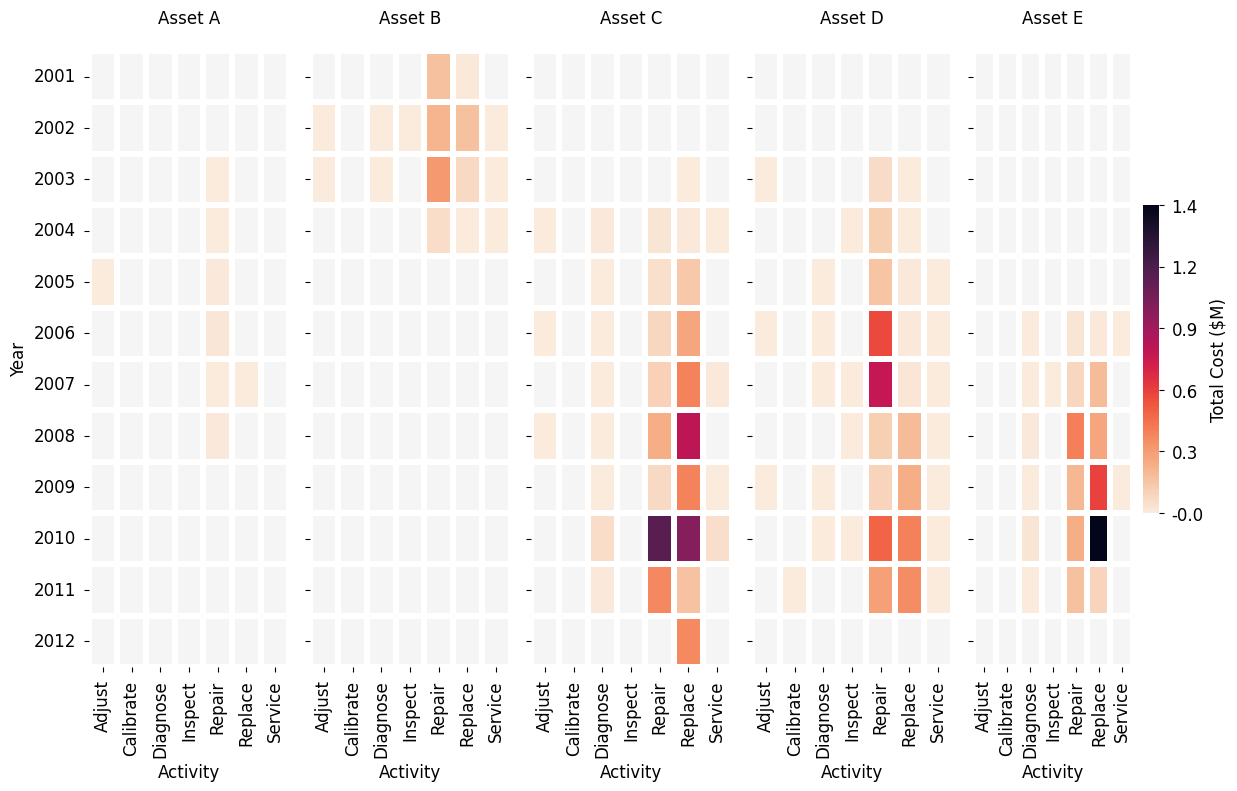

In [19]:
create_query_6_heatmap(query=query_6, save_path='./assets/query_6_heatmap_plot.pdf')

In [20]:
# CQ7. What are the cost implications of components participating in different states or processes?
query_7 = '''
MATCH p=(r:Record)-[:MENTIONS]->(m)-[ra:HAS_AGENT]-(n)<-[:MENTIONS]-(r)-[:MENTIONS]->(q)<-[rp:HAS_PATIENT]-(m)
WHERE m.name CONTAINS 'leak' AND id(rp) IN r.relationIds AND id(ra) IN r.relationIds 
WITH r.floc AS system, m.name AS event, q.name AS substance, n.name AS component, COUNT(*) AS count, SUM(r.cost) AS totalCost
WHERE totalCost > 5000
RETURN system, component, event, substance, count, totalCost
ORDER BY system, totalCost DESC
'''

In [21]:
query_7_df = fetch_data(query=query_7)
query_7_df

,system,component,event,substance,count,totalCost
0,B,engine,leak,oil,5,21399.24
1,B,cylinder rod,leak,oil,1,9739.28
2,B,control valve,leak,oil,7,9101.78
3,B,cooler,leak,oil,1,5933.86
4,C,grease pump,leak,oil,1,14790.00
5,C,engine,leak,oil,3,7768.07
6,D,final drive,leak,oil,2,26100.41
7,D,engine,leak,oil,11,6074.96
8,D,machine,leak,oil,2,5363.62
9,D,high pressure filter,leak,oil,2,5319.38


### Knowledge Discovery and Management

In [22]:
# CQ8. Provide a taxonomical breakdown of X. (X = engine)
# Note: the return statement of this query has been modified to allow it be represented as a table. Replace it with `RETURN p` and execute within Neo4J to see the sugraph network.
query_8 = '''
MATCH p=(n)-[r:HAS_PART]->(m)
WHERE labels(n)[0] CONTAINS 'Object' AND labels(m)[0] CONTAINS 'Object' AND n.name = 'engine' AND r.frequency > 1
RETURN n.name AS component, m.name AS part, r.frequency AS count
'''

In [23]:
query_8_df = fetch_data(query=query_8)
# Show the top 25 rows
query_8_df.head(25)

,component,part,count
0,engine,fire suppression,2
1,engine,fan,23
2,engine,oil hose,2
3,engine,warning light,5
4,engine,air cleaner,4
5,engine,hose,3
6,engine,temperature sender,3
7,engine,exhaust,18
8,engine,starter motor,8
9,engine,belt,4
